# Self-Driving with Tensorflow

Data usada:

- Enlace Github: [driving-datasets](https://github.com/SullyChen/driving-datasets)

Data a probar

- Enlace [kitti datos de navegacion](http://www.cvlibs.net/datasets/kitti/raw_data.php)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow
print(tensorflow.__version__)

2.6.0


In [3]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%tensorflow_version 2.x
from tensorflow.python.keras import backend as K
import tensorflow as tf
%matplotlib inline

tf.random.set_seed(0)

In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8

#Dynamically grow the memory used on the GPU
config.gpu_options.allow_growth = True

# #To log device placement (on which device the operation ran)
# #Nothing gets printed in Jupyter, only if you run it standalone
# config.log_device_placement = True

sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

In [5]:
K.get_session()


In [6]:
import cv2
import os
import glob

import matplotlib.image as mpimg

import pylab as pl
from PIL import Image

In [7]:
!nvidia-smi

Fri Aug 27 21:19:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    70W / 149W |    121MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Carga de imágenes y datos

In [9]:
path_drive = './drive/MyDrive/data/selfdriving/src/img/07012018/'

In [10]:
width = 100
height = 100

In [ ]:
!ls -la ./drive/MyDrive/data/selfdriving/src/img/

total 3031935
drwx------ 2 root root       4096 Aug 10 04:48 07012018
-r-------- 1 root root 3104696902 Jul  2  2018 07012018.zip


In [ ]:
!unzip ./drive/MyDrive/data/selfdriving/src/img/07012018.zip -d ./drive/MyDrive/data/selfdriving/src/img/07012018

Archive:  ./drive/MyDrive/data/selfdriving/src/img/07012018.zip
replace ./drive/MyDrive/data/selfdriving/src/img/07012018/data/9733.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls -la ./drive/MyDrive/data/selfdriving/src/img/07012018/

total 2714
drwx------ 2 root root    4096 Aug 10 04:48 data
-rw------- 1 root root 2770706 Jul  2  2018 data.txt
drwx------ 2 root root    4096 Jul  2  2018 __MACOSX


In [ ]:
data = pd.read_csv(path_drive + 'data.txt', sep=" ", header=None)
data.sample(5)

,0,1,2
40691,40691.jpg,"16.240000,2018-07-01",17:45:42:396
24725,24725.jpg,"2.620000,2018-07-01",17:31:37:730
22960,22960.jpg,"7.460000,2018-07-01",17:30:07:305
46975,46975.jpg,"4.340000,2018-07-01",17:51:17:515
52489,52489.jpg,"3.730000,2018-07-01",17:56:14:480


In [ ]:
def get_angle(text:str)->str:
  return text.split(',')[0]

def get_date(text:str)->str:
  return text.split(',')[1]

In [ ]:
df = pd.DataFrame()
df['img']   = data[0]
df['angle'] = data[1].apply(get_angle)
df['date']  = data[1].apply(get_date)
df['time']  = data[2]

In [ ]:
# df = df.sample(int(len(df)*.1))

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Carga de Imagenes desde Colab

In [ ]:
def load_images_drive(file):
  image = cv2.imread(r"{}/data/{}".format(path_drive,file))
  image = cv2.resize(
    (cv2.cvtColor(image, cv2.COLOR_RGB2HSV))[:, :, 1], (width, height)
  )
  return image

Carga de Imagenes desde Jupiter Lab

In [ ]:
def load_images_local(files):
    images = []
    for file in files:
        image = cv2.imread(r"{}/data/{}".format(path_drive,file))
        image = cv2.resize(image, dsize=(width,height))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)
    return images

In [ ]:
images = df.img.progress_apply(load_images_drive)

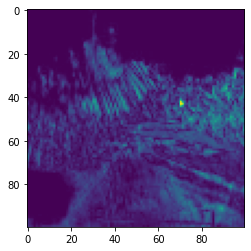

In [ ]:
plt.imshow(images[0])

In [ ]:
angles = df.angle.progress_apply(lambda angle: float(angle)  * math.pi / 180)

In [ ]:
angles = np.array(angles).astype('float32')

In [ ]:
angles.shape

(63825,)

Punto de Guardado y Carga de los datos en Drive, para su posterior trabajo y mayor rapidez de lectura y transformación de datos

In [11]:
import pickle

In [ ]:
def save_with_pickle():
  with open(path_drive + "images.pkl", "wb") as f:
    pickle.dump(images, f, protocol=4)
  with open(path_drive + "angles.pkl", "wb") as f:
    pickle.dump(angles, f, protocol=4)

In [12]:
def load_from_pickle():
  with open(path_drive + "images_wb (1).pkl", "rb") as f:
    images = np.array(pickle.load(f))
  with open(path_drive + "angles_wb (1).pkl", "rb") as f:
    angles = np.array(pickle.load(f))

  return images, angles

In [30]:
images, angles = load_from_pickle()

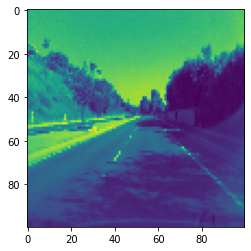

In [31]:
plt.imshow(images[0])

In [32]:
angles[0]

0.0

In [33]:
images.shape

(63825, 100, 100)

In [34]:
angles.shape

(63825,)

## Data de Entrenamiento y Test

In [35]:
from sklearn.utils import shuffle
images, angles = shuffle(images, angles)

In [36]:
def get_data(x, y):
  sizeTrain = (int)(len(x)*.7)
  return (x[:sizeTrain], np.array(y[:sizeTrain])), (x[sizeTrain:], np.array(y[sizeTrain:]))

In [37]:
(x_train, y_train), (x_test, y_test) = get_data(images, angles)
mean = x_train.mean()
std = x_train.std()
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std
#x_train = x_train / 127.5 - 1.
#x_test = x_test / 127.5 - 1.

print(f'Train -> x: {x_train.shape}')
print(f'         y: {y_train.shape}')
print(f'Test -> x: {x_test.shape}')
print(f'        y: {y_test.shape}')

Train -> x: (44677, 100, 100)
         y: (44677,)
Test -> x: (19148, 100, 100)
        y: (19148,)


In [38]:
x_train.min(), x_train.max()

(-1.7617201, 1.9827802)

In [39]:
if x_train.ndim == 3:
    x_train = x_train[...,None]
    x_test = x_test[..., None]
    print(x_train.shape, x_test.shape)


(44677, 100, 100, 1) (19148, 100, 100, 1)


## Arquitectura de los modelos

In [16]:
# Model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPool2D,GlobalAvgPool2D, Lambda, Activation, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2

In [149]:
K.clear_session()

lr = 0.00001
bs = 256
nb = math.ceil(len(x_train)/bs) # Nro de batches
l2_w = 1e-4

In [153]:
def plot_model_and_save_image(model, file_name="model.png"):   
  from tensorflow.keras.utils import plot_model
  return plot_model(model, to_file=file_name, show_shapes=True)

### Arquitectura propuesta

In [ ]:
model = Sequential([
  Conv2D(32, (3,3), activation='relu', padding='same', use_bias=False,kernel_initializer='he_normal', input_shape=(width,height,1)),
  MaxPool2D((2,2), strides= 2, padding='valid'),
  BatchNormalization(),
  Conv2D(32, (3,3), activation='relu', padding='same', use_bias=False,kernel_initializer='he_normal', kernel_regularizer=l2(l2_w)),
  MaxPool2D((2,2), strides= 2, padding='valid'),
  BatchNormalization(),
  Conv2D(64, (3,3), activation='relu', padding='same', use_bias=False,kernel_initializer='he_normal', kernel_regularizer=l2(l2_w)),
  MaxPool2D((2,2), strides= 2, padding='valid'),
  BatchNormalization(),
  Conv2D(128, (3,3), activation='relu', padding='same', use_bias=False,kernel_initializer='he_normal', kernel_regularizer=l2(l2_w)),
  MaxPool2D((2,2),strides= 2,padding='valid'),
  BatchNormalization(),
  Conv2D(128, (3,3), activation='relu', padding='same', use_bias=False,kernel_initializer='he_normal', kernel_regularizer=l2(l2_w)),
  MaxPool2D((2,2),strides= 2,padding='valid'),
  
  Flatten(),
  Dropout(0.3),
  Dense(units=1024),
  Dense(units=256),
  Dense(units=64),
  Dense(units=1),
])

model.compile(optimizer=Adam(lr=0.0001), loss="mse", metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 100, 100, 32)      288       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 32)        9216      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 64)       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


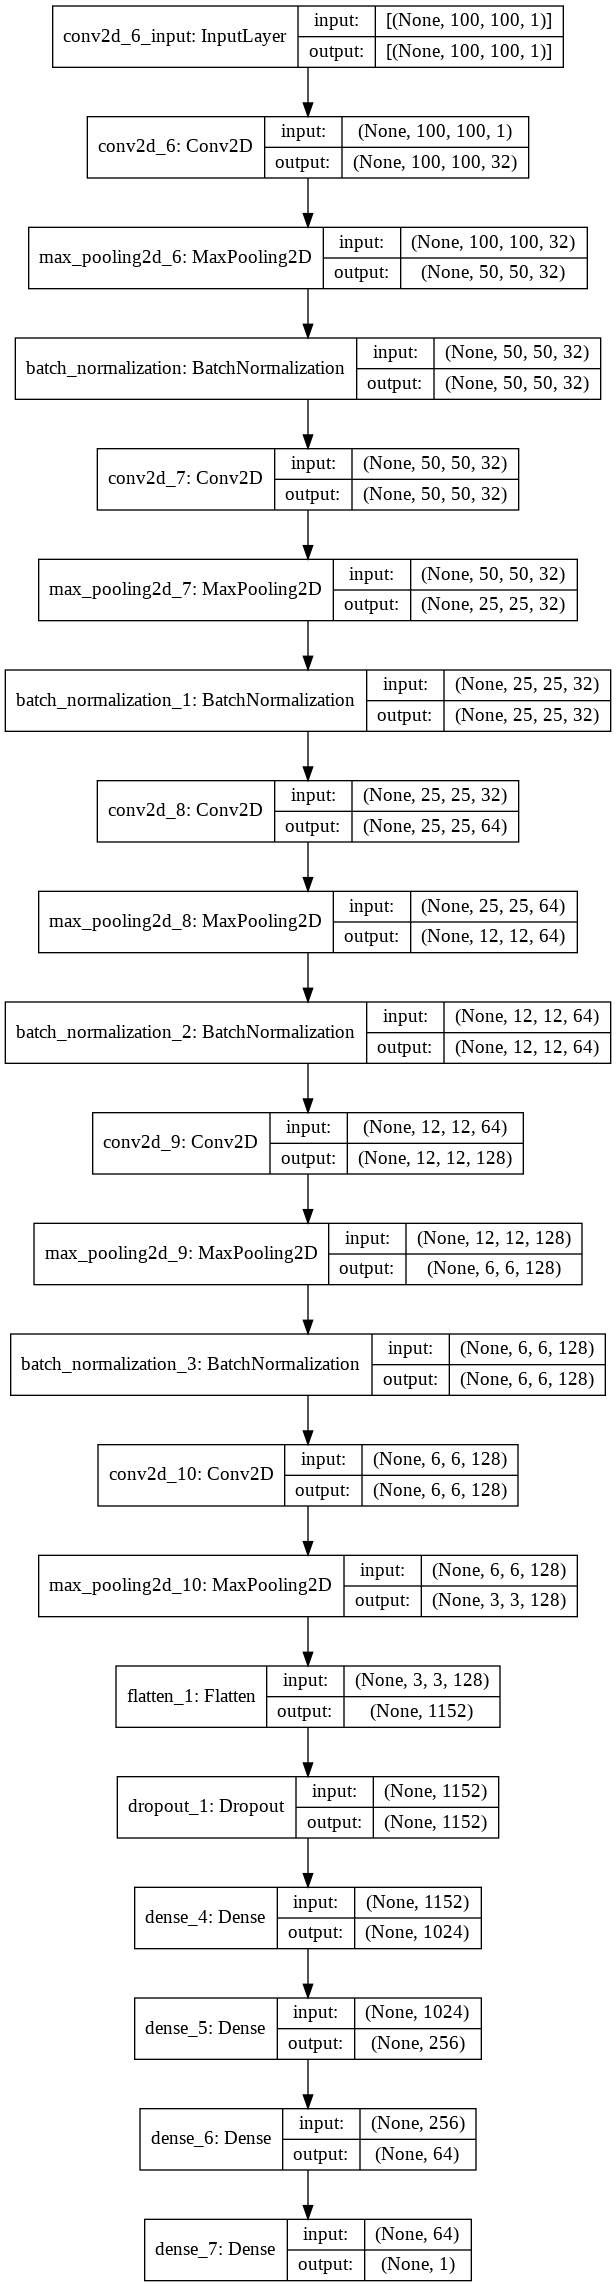

In [ ]:
plot_model_and_save_image(model, file_name="model.png")

### Arquitectura del Paper [End to End Learning for Self-Driving Cars](https://arxiv.org/pdf/1604.07316v1.pdf)

In [157]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(width,height,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), padding='valid'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), padding='valid'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), padding='valid'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), padding='valid'))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), padding='valid'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), padding='valid'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024))
model.add(Dense(256))
model.add(Dense(64))
model.add(Dense(1))

model.compile(optimizer='adam', loss="mse", metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        1

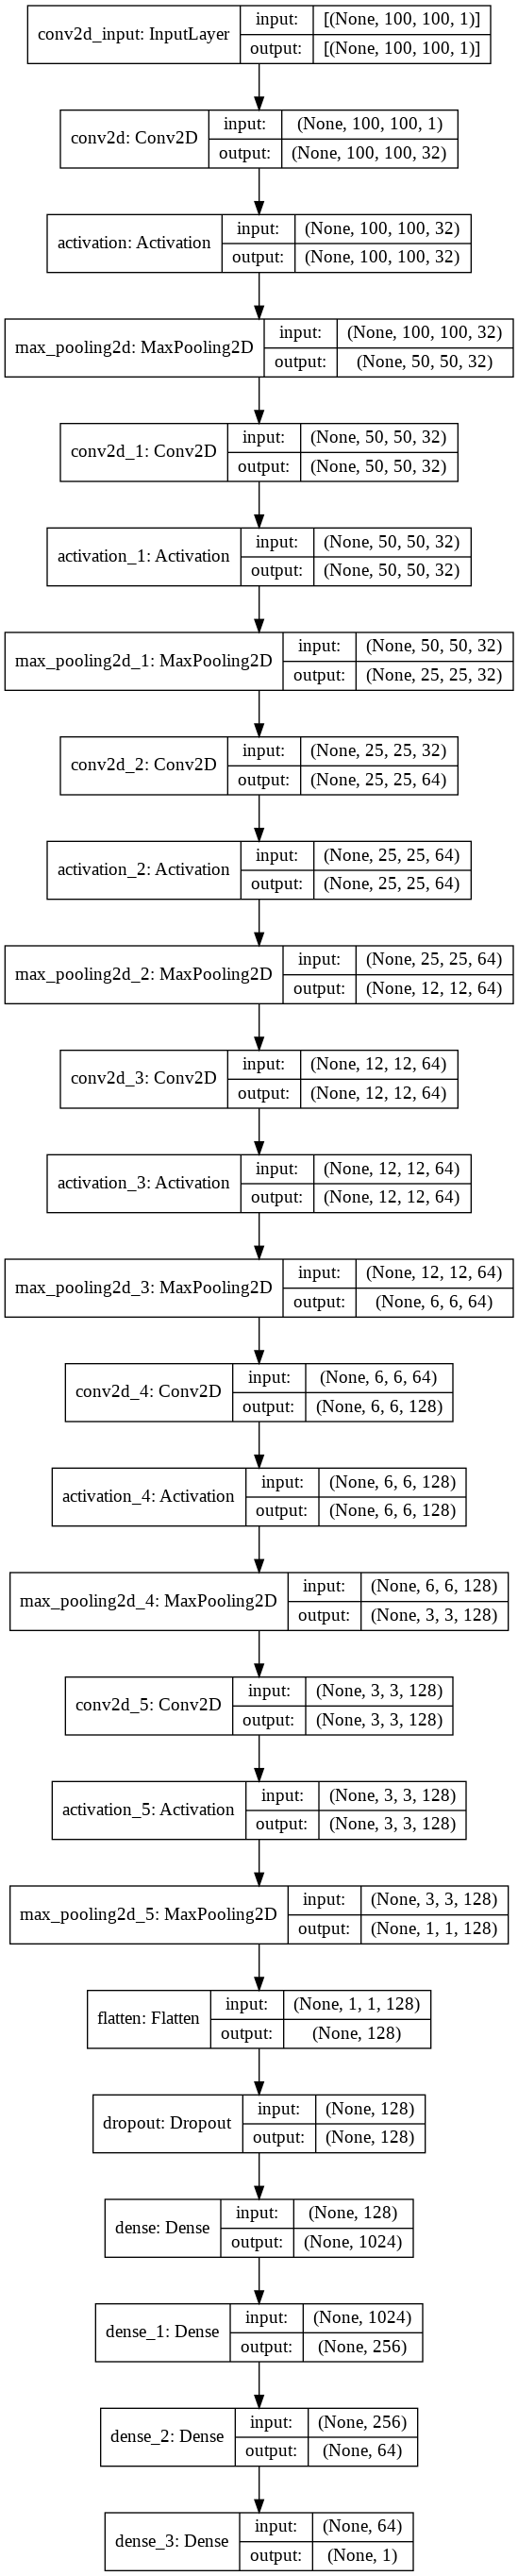

In [158]:
plot_model_and_save_image(model, file_name="model.png")

## Entrenamiento de los Modelos

### Entrenamiento del modelo propuesto

In [ ]:
log = model.fit(x_train, y_train, batch_size=bs, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
175/175 [==============================] - 30s 161ms/step - loss: 4.2502 - accuracy: 0.0243 - val_loss: 0.3406 - val_accuracy: 0.0368
Epoch 2/10
175/175 [==============================] - 25s 142ms/step - loss: 0.5429 - accuracy: 0.0313 - val_loss: 0.2482 - val_accuracy: 0.0391
Epoch 3/10
175/175 [==============================] - 25s 142ms/step - loss: 0.2952 - accuracy: 0.0366 - val_loss: 0.2277 - val_accuracy: 0.0391
Epoch 4/10
175/175 [==============================] - 25s 141ms/step - loss: 0.2599 - accuracy: 0.0378 - val_loss: 0.2326 - val_accuracy: 0.0393
Epoch 5/10
175/175 [==============================] - 25s 141ms/step - loss: 0.2558 - accuracy: 0.0380 - val_loss: 0.2256 - val_accuracy: 0.0389
Epoch 6/10
175/175 [==============================] - 25s 141ms/step - loss: 0.2624 - accuracy: 0.0375 - val_loss: 0.2417 - val_accuracy: 0.0395
Epoch 7/10
175/175 [==============================] - 25s 141ms/step - loss: 0.2536 - accuracy: 0.0378 - val_loss: 0.2204 - val_ac

### Entrenamiento del modelo del paper

In [159]:
log = model.fit(x_train, y_train, batch_size=bs, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
175/175 [==============================] - 31s 160ms/step - loss: 0.2045 - accuracy: 0.0393 - val_loss: 0.1618 - val_accuracy: 0.0370
Epoch 2/10
175/175 [==============================] - 25s 144ms/step - loss: 0.1421 - accuracy: 0.0386 - val_loss: 0.0916 - val_accuracy: 0.0372
Epoch 3/10
175/175 [==============================] - 25s 144ms/step - loss: 0.0864 - accuracy: 0.0386 - val_loss: 0.0587 - val_accuracy: 0.0369
Epoch 4/10
175/175 [==============================] - 25s 144ms/step - loss: 0.0611 - accuracy: 0.0384 - val_loss: 0.0425 - val_accuracy: 0.0363
Epoch 5/10
175/175 [==============================] - 25s 144ms/step - loss: 0.0469 - accuracy: 0.0383 - val_loss: 0.0319 - val_accuracy: 0.0368
Epoch 6/10
175/175 [==============================] - 25s 144ms/step - loss: 0.0387 - accuracy: 0.0385 - val_loss: 0.0321 - val_accuracy: 0.0365
Epoch 7/10
175/175 [==============================] - 25s 144ms/step - loss: 0.0371 - accuracy: 0.0384 - val_loss: 0.0247 - val_ac

## Resultados

In [150]:
def show_results(model, log):
  loss, acc = model.evaluate(x_test, y_test, batch_size=512, verbose=False)
  print(f'Loss     = {loss:.4f}')
  print(f'Accuracy = {acc:.4f}')
  
  val_loss = log.history['val_loss']
  val_acc = log.history['val_accuracy']
      
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  ax1, ax2 = axes
  ax1.plot(log.history['loss'], label='train')
  ax1.plot(val_loss, label='test')
  ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
  ax2.plot(log.history['accuracy'], label='train')
  ax2.plot(val_acc, label='test')
  ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
  for ax in axes: ax.legend()

### Resultados del Modelo Propuesto

Loss     = 0.2140
Accuracy = 0.0382


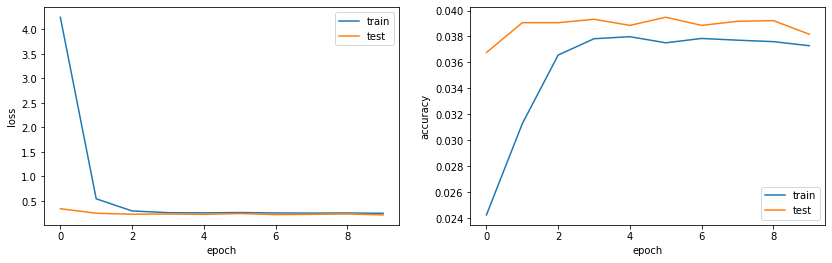

In [ ]:
show_results(model, log)

### Resultados del Modelo del Paper

Loss     = 0.2175
Accuracy = 0.0367


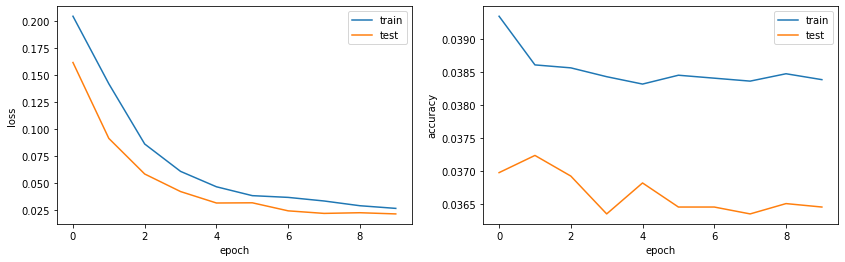

In [171]:
show_results(model, log)

Guardando el modelo...

In [ ]:
model.save( path_drive + 'model.h5')

Cargando el modelo...

In [13]:
from tensorflow.keras.models import load_model


In [182]:
model = load_model( path_drive + 'model.h5')

In [168]:
y_predictions = model.predict(x_test)

In [169]:
y_predictions = np.reshape(y_predictions, y_predictions.shape[0])

In [170]:
y_predictions.shape

(19148,)

## Identificación de Casos donde predijo practicamente lo contrario el Modelo Propuesto

### Caso 1

In [45]:
Y = y_predictions - y_test

In [46]:
Y.max()

5.8862896

In [47]:
x = np.where(Y == Y.max())

In [48]:
x[0][0]

4024

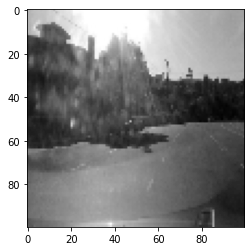

In [50]:
plt.imshow(np.reshape(x_test[4024], (100,100)), cmap='gray')

In [90]:
y_test[4024], y_predictions[4024] 

(-5.7622046, 0.124085106)

### Caso 2

In [91]:
x = np.where(Y == Y.min())

In [92]:
x[0][0]

12441

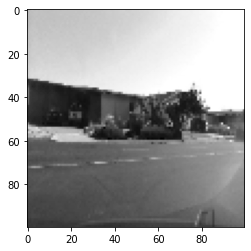

In [93]:
plt.imshow(np.reshape(x_test[12441], (100,100)), cmap='gray')

In [94]:
y_test[12441], y_predictions[12441] 

(4.3982296, 0.76635915)

## Identificación de Casos donde predijo practicamente lo mismo

### Caso 3

In [124]:
x = np.where(abs(Y) <= 0.01)

In [125]:
x

(array([    6,    10,    16,    17,    58,    62,    87,    95,   103,
          104,   116,   126,   162,   165,   191,   250,   265,   270,
          275,   284,   286,   294,   309,   343,   354,   396,   410,
          413,   425,   443,   446,   451,   457,   458,   465,   470,
          485,   506,   534,   653,   706,   711,   718,   726,   736,
          791,   798,   805,   834,   853,   870,   887,   903,   921,
          941,  1006,  1014,  1076,  1091,  1107,  1129,  1133,  1158,
         1168,  1209,  1269,  1303,  1310,  1325,  1351,  1372,  1397,
         1423,  1444,  1485,  1522,  1555,  1558,  1561,  1565,  1571,
         1573,  1605,  1607,  1622,  1658,  1662,  1689,  1729,  1744,
         1748,  1774,  1795,  1816,  1817,  1824,  1845,  1862,  1874,
         1885,  1896,  1897,  1907,  1918,  1922,  1967,  1989,  1999,
         2001,  2038,  2082,  2114,  2122,  2138,  2139,  2158,  2177,
         2182,  2190,  2192,  2231,  2240,  2251,  2253,  2261,  2329,
      

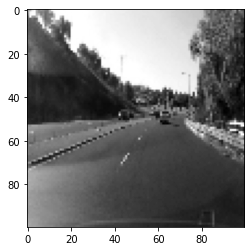

In [143]:
plt.imshow(np.reshape(x_test[10], (100,100)), cmap='gray')

In [144]:
y_test[10], y_predictions[10] 

(0.31328663, 0.313254)

## Extracción de Capas de los modelos

In [172]:
from matplotlib import pyplot
for i in range(len(model.layers)):
	layer = model.layers[i]
	if 'conv' not in layer.name:
		continue
	print(i, layer.name, layer.output.shape)

0 conv2d_6 (None, 100, 100, 32)
3 conv2d_7 (None, 50, 50, 32)
6 conv2d_8 (None, 25, 25, 64)
9 conv2d_9 (None, 12, 12, 128)
12 conv2d_10 (None, 6, 6, 128)


In [183]:
from matplotlib import pyplot
for i in range(len(model.layers)):
	layer = model.layers[i]
	if 'conv' not in layer.name:
		continue
	print(i, layer.name, layer.output.shape)

0 conv2d (None, 100, 100, 32)
3 conv2d_1 (None, 50, 50, 32)
6 conv2d_2 (None, 25, 25, 64)
9 conv2d_3 (None, 12, 12, 64)
12 conv2d_4 (None, 6, 6, 128)
15 conv2d_5 (None, 3, 3, 128)


In [184]:
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [178]:
def get_images_cnn(index):
  feature_maps  = model.predict(np.reshape(x_test[index], (1, width,height,1)))
  ix = 1
  pyplot.figure(figsize=(20,20))
  for _ in range(4):
    for _ in range(8):
      ax = pyplot.subplot(8, 8, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
      ix += 1
  pyplot.show()

## ¿Qué ve el Modelo del Paper?

### Caso 1

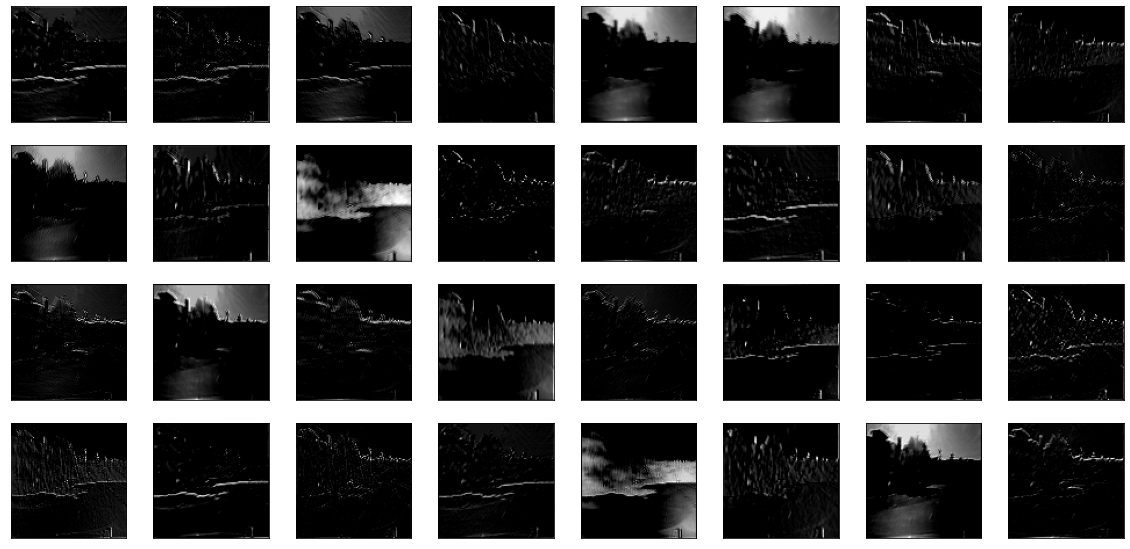

In [185]:
get_images_cnn(4024)

### Caso 2

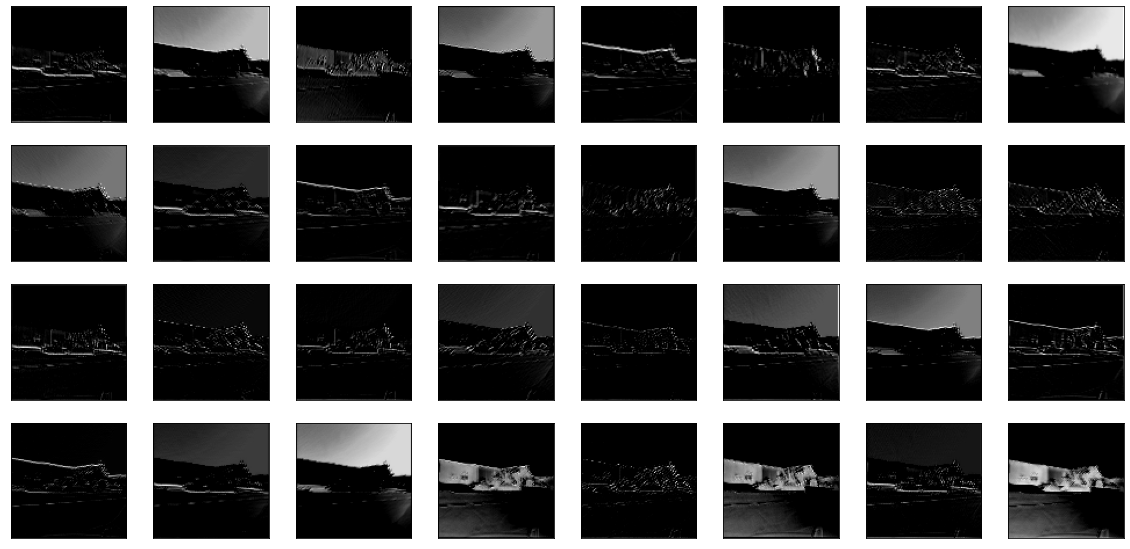

In [165]:
get_images_cnn(12441)

### Caso 3

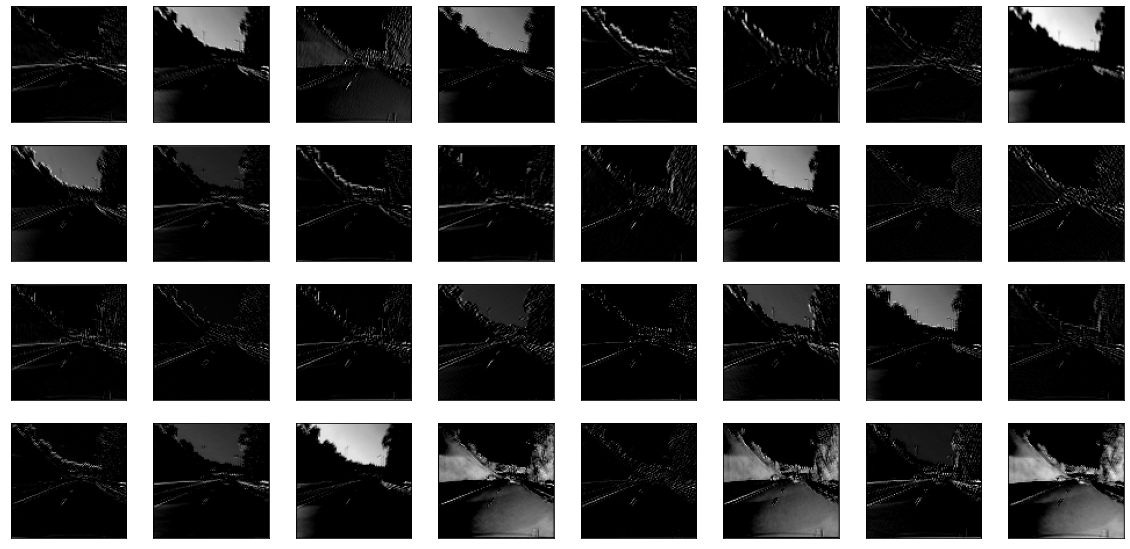

In [166]:
get_images_cnn(10)

## ¿Qué ve el Modelo Propuesto?

### Caso 1

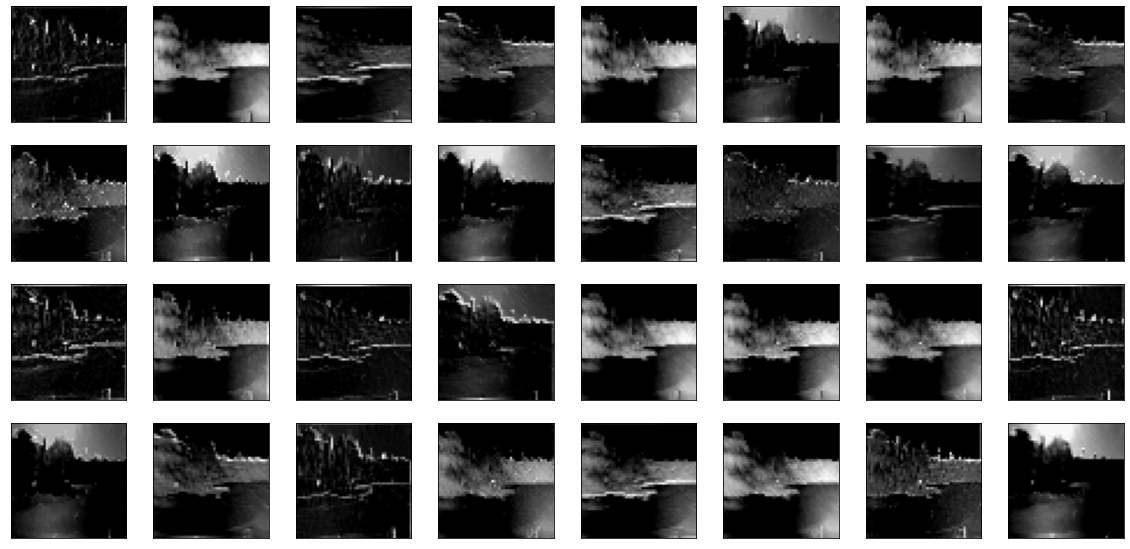

In [179]:
get_images_cnn(4024)

### Caso 2

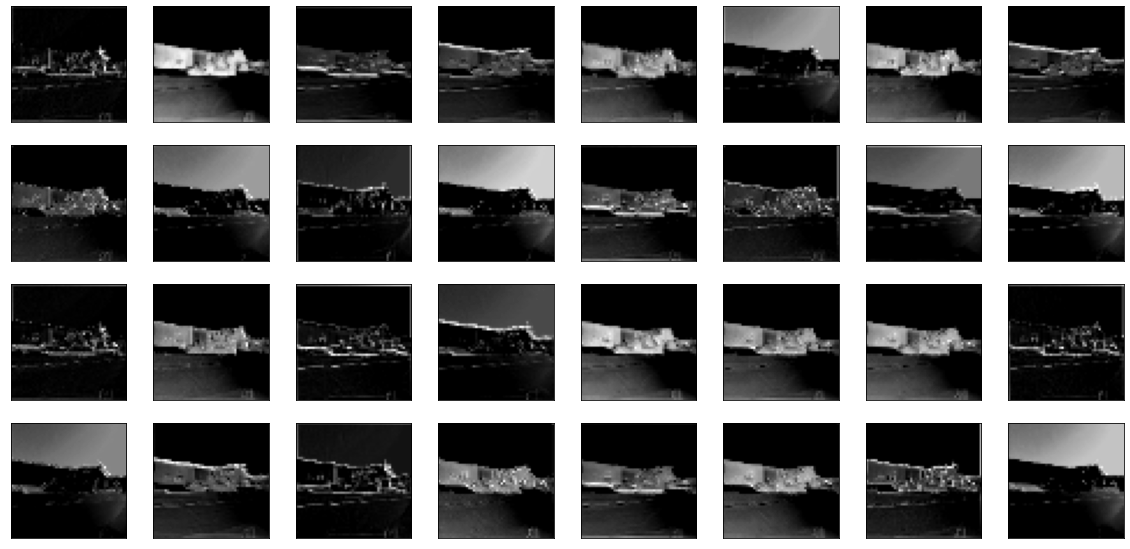

In [180]:
get_images_cnn(12441)

### Caso 3

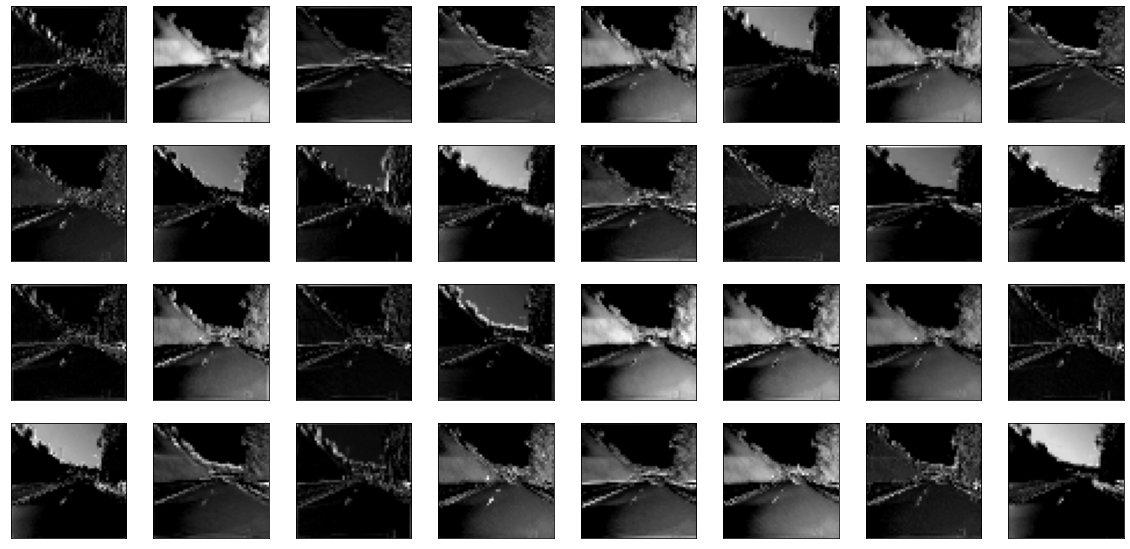

In [181]:
get_images_cnn(10)